In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pams.order import Order, MARKET_ORDER, LIMIT_ORDER
from pams.order_book import OrderBook
import pandas as pd
from pandas import DataFrame, Series
from typing import Optional, TypeVar

MarketID = TypeVar("MarketID")

## Goal1: convert ```OrderBook``` to following ```DataFrame```.

| index | limit buy order volume | limit sell order volume | market order volume |
|-------|------------------------|-------------------------|---------------------|
|  OVER |          0             |       -1000             |           0         |
|  1010 |          0             |           0             |           0         |
|  1009 |          0             |           0             |           0         |
|  1008 |          0             |           0             |           0         |
|  1007 |          0             |           0             |           0         |
|  1008 |          0             |           0             |           0         |
|  1005 |          0             |           0             |           0         |
|  1004 |          0             |           0             |           0         |
|  1003 |          0             |           0             |           0         |
|  1002 |          0             |           0             |           0         |
|  1001 |          0             |        -100             |         100         |
|  1000 |          0             |           0             |           0         |
|   999 |        200             |           0             |        -100         |
|   998 |          0             |           0             |           0         |
|   997 |          0             |           0             |           0         |
|   996 |          0             |           0             |           0         |
|   995 |          0             |           0             |           0         |
|   994 |          0             |           0             |           0         |
|   993 |          0             |           0             |           0         |
|   992 |          0             |           0             |           0         |
|   991 |          0             |           0             |           0         |
|   990 |          0             |           0             |           0         |
| UNDER |       1500             |           0             |           0         |

Create toy order book.

In [2]:
tick_size: int = 1
draw_tick_num: int = 10
buy_order_book: OrderBook = OrderBook(is_buy=True)
sell_order_book: OrderBook = OrderBook(is_buy=False)
sell_order_book.add(order=Order(1,0,False,LIMIT_ORDER,volume=1000,price=1101,order_id=1))
sell_order_book.add(order=Order(2,0,False,LIMIT_ORDER,volume=100,price=1001,order_id=2))
sell_order_book.add(order=Order(3,0,False,MARKET_ORDER,volume=50,price=None,order_id=3))
sell_order_book.add(order=Order(4,0,False,MARKET_ORDER,volume=50,price=None,order_id=4))
buy_order_book.add(order=Order(5,0,True,MARKET_ORDER,volume=100,price=None,order_id=5))
buy_order_book.add(order=Order(6,0,True,LIMIT_ORDER,volume=200,price=999,order_id=6))
buy_order_book.add(order=Order(7,0,True,LIMIT_ORDER,volume=1500,price=989,order_id=7))

Check how ```OrderBook.get_price_volume()``` works.

In [3]:
sell_price_volume_dic: dict[Optional[float], int] = sell_order_book.get_price_volume()
buy_price_volume_dic: dict[Optional[float], int] = buy_order_book.get_price_volume()
print(f"sell: {sell_price_volume_dic}")
print(f"buy: {buy_price_volume_dic}")

sell: {None: 100, 1001: 100, 1101: 1000}
buy: {None: 100, 999: 200, 989: 1500}


get mid price from orderbooks of both sides.

In [4]:
sell_prices: Optional[list[float]] = list(sell_price_volume_dic.keys())
sell_prices: list[float] = [sell_price for sell_price in sell_prices if sell_price != None]
buy_prices: Optional[list[float]] = list(buy_price_volume_dic.keys())
buy_prices: list[float] = [buy_price for buy_price in buy_prices if buy_price != None]
best_sell_price: Optional[float] = None
if len(sell_prices) != 0:
    best_sell_price = min(sell_prices)
best_buy_price: Optional[float] = None
if len(buy_prices) != 0:
    best_buy_price = max(buy_prices)
mid_price: Optional[float] = None
if (best_sell_price == None) and (best_buy_price != None):
    mid_price = best_buy_price + tick_size
    best_sell_price = mid_price
elif (best_sell_price != None) and (best_buy_price == None):
    mid_price = best_sell_price - tick_size
    best_buy_price = mid_price
elif (best_sell_price != None) and (best_buy_price != None):
    mid_price = (best_sell_price + best_buy_price) / 2
print(f"mid price: {mid_price}")

mid price: 1000.0


convert mid price to tick level.

In [5]:
mid_price_level: int = math.ceil(mid_price / tick_size)
mid_price: float = mid_price_level * tick_size
print(f"mid price level:{mid_price_level} mid price:{mid_price}")

mid price level:1000 mid price:1000


initialize dataframe from tick-level coordinated mid price and tick size.

In [6]:
prices_arr: ndarray = np.arange(
    mid_price - draw_tick_num * tick_size,
    mid_price + draw_tick_num * tick_size + 1,
    tick_size,
    dtype=float
)
prices_list: list[str | float] = ["OVER"] + list(np.sort(prices_arr)[::-1]) + ["UNDER"]
orderbook_df: DataFrame = pd.DataFrame(
    data=np.zeros((len(prices_list), 3)),
    index=prices_list,
    columns=["limit buy order volume", "limit sell order volume", "market order volume"],
    dtype=float
)
orderbook_df


,limit buy order volume,limit sell order volume,market order volume
OVER,0.0,0.0,0.0
1010.0,0.0,0.0,0.0
1009.0,0.0,0.0,0.0
1008.0,0.0,0.0,0.0
1007.0,0.0,0.0,0.0
1006.0,0.0,0.0,0.0
1005.0,0.0,0.0,0.0
1004.0,0.0,0.0,0.0
1003.0,0.0,0.0,0.0
1002.0,0.0,0.0,0.0


set values to each columns in the dataframe. (market order)

In [7]:
sell_marketorder_volume: int = sell_price_volume_dic[None]
buy_marketorder_volume: int = buy_price_volume_dic[None]
orderbook_df.loc[best_buy_price, "market order volume"] = -sell_marketorder_volume
orderbook_df.loc[best_sell_price, "market order volume"] = buy_marketorder_volume
orderbook_df

,limit buy order volume,limit sell order volume,market order volume
OVER,0.0,0.0,0.0
1010.0,0.0,0.0,0.0
1009.0,0.0,0.0,0.0
1008.0,0.0,0.0,0.0
1007.0,0.0,0.0,0.0
1006.0,0.0,0.0,0.0
1005.0,0.0,0.0,0.0
1004.0,0.0,0.0,0.0
1003.0,0.0,0.0,0.0
1002.0,0.0,0.0,0.0


set values to each columns in the dataframe. (limit order)

In [8]:
for buy_price in buy_prices:
    if buy_price in orderbook_df.index:
        orderbook_df.loc[buy_price, "limit buy order volume"] = buy_price_volume_dic[buy_price]
    else:
        orderbook_df.loc["UNDER", "limit buy order volume"] += buy_price_volume_dic[buy_price]
for sell_price in sell_prices:
    if sell_price in orderbook_df.index:
        orderbook_df.loc[sell_price, "limit sell order volume"] = - sell_price_volume_dic[sell_price]
    else:
        orderbook_df.loc["OVER", "limit sell order volume"] -= sell_price_volume_dic[sell_price]
orderbook_df

,limit buy order volume,limit sell order volume,market order volume
OVER,0.0,-1000.0,0.0
1010.0,0.0,0.0,0.0
1009.0,0.0,0.0,0.0
1008.0,0.0,0.0,0.0
1007.0,0.0,0.0,0.0
1006.0,0.0,0.0,0.0
1005.0,0.0,0.0,0.0
1004.0,0.0,0.0,0.0
1003.0,0.0,0.0,0.0
1002.0,0.0,0.0,0.0


## Goal2: visualize orderbook.

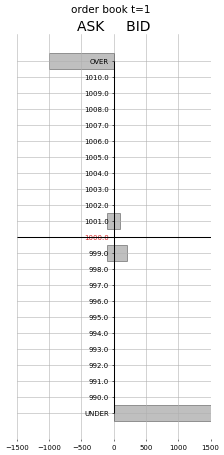

In [26]:
t=1
prices_w_str: Series = orderbook_df.index.values
prices: Series = prices_w_str.copy()
prices[0] = prices_w_str[1] + tick_size
prices[-1] = prices_w_str[-2] - tick_size
fig = plt.figure(figsize=(5,10), dpi=50, facecolor="w")
fig.suptitle(f"order book t={t}", size=15)
ax1: plt.Axes = fig.add_subplot(1,1,1)
ax1.grid()
sell_volumes: Series = orderbook_df["limit sell order volume"]
buy_volumes: Series = orderbook_df["limit buy order volume"]
marketorder_volumes: Series = orderbook_df["market order volume"]
ax1.vlines(0, prices[0], prices[-1], colors="black")
ax1.barh(prices, buy_volumes, align="center", height=1.0,
        color="gray", edgecolor="black", alpha=0.5)
ax1.barh(prices, sell_volumes, align="center", height=1.0,
        color="gray", edgecolor="black", alpha=0.5)
ax1.barh(prices, marketorder_volumes, align="center", height=1.0,
        color="gray", edgecolor="black", alpha=0.5)
#ax1.set_ylim([prices[-1]+4*tick_size, prices[0]-4*tick_size])
ax1.set_yticks(list(prices))
ax1.set_yticklabels(list(prices_w_str))
max_volume: int = (sell_volumes.abs() + buy_volumes + marketorder_volumes).sort_values().values[-1]
ax1.set_xlim([-max_volume, max_volume])
ax1.hlines(mid_price, -max_volume, max_volume, color="black")
ax1.set_title(f"ASK     BID", size=20)
for p in ["left", "top", "right", "bottom"]:
    ax1.spines[p].set_visible(False)
    if p == "left":
        ax1.spines[p].set_position("zero")
labels = ax1.get_yticklabels()
labels[11].set_color("tab:red")
fig.subplots_adjust(top=0.92, hspace=0.2)

## Goal3: create order book video log.

In [1]:
from orderbook_logger import OrderBookSaver
from pams.runners import SequentialRunner
import pathlib
import random
import warnings
warnings.simplefilter('ignore')

config = {
	"simulation": {
		"markets": ["Market"],
		"agents": ["FCNAgents"],
		"sessions": [
			{	"sessionName": 0,
				"iterationSteps": 100,
				"withOrderPlacement": True,
				"withOrderExecution": False,
				"withPrint": True,
				"hiFrequencySubmitRate": 1.0
			},
			{	"sessionName": 1,
				"iterationSteps": 100,
				"withOrderPlacement": True,
				"withOrderExecution": True,
				"withPrint": True
			}
		]
	},
	"Market": {
		"class": "Market",
		"tickSize": 1.,
		"marketPrice": 100.0
	},
	"FCNAgents": {
		"class": "FCNAgent",
		"numAgents": 100,
		"markets": ["Market"],
		"assetVolume": 50,
		"cashAmount": 10000,
		"fundamentalWeight": {"expon": [1.0]},
		"chartWeight": {"expon": [0.0]},
		"noiseWeight": {"expon": [1.0]},
		"meanReversionTime":{"uniform":[50,100]},
		"noiseScale": 0.001,
		"timeWindowSize": [100, 200],
		"orderMargin": [0.0, 0.1]
	}
}

In [2]:
videos_path = pathlib.Path("../videos")
orderbook_saver = OrderBookSaver(videos_path, video_width=2700, video_height=2700)#, pending_img_save_path)
runner = SequentialRunner(
    settings=config,
    prng=random.Random(42),
    logger=orderbook_saver,
)
runner.main()

# INITIALIZATION TIME 0.002918
# EXECUTION TIME 506.676231
